# What drives the price of a car?

![](images/kurt.jpeg)

## Introduction - Business Understanding
In United States, the Passenger Car market (New & Used) is massive. Annually about :
- 15 million **NEW** passenger cars & light trucks (like Toyota Tacoma, Ford-150 etc.) are sold, generating US\$ 636 Billion in sales (2019)
- 39 million **USED** cars are sold, i.e. more than twice the number of NEW cars, totalling around US\$ 841 Billion in sales (2019) 

The Used car market is primarily driven (pun intented) by large American middle class who own more than 1 car per household. With the virtually non-existant public transport(other than in few Metropolitan cities) having a 2nd car is a 'necessity' rather than a luxury.

Used cars dealer all over try to price their used car inventory to maximize their sales based on several factors. Some of the key factors that drive car prices are:
1. Year
2. Manufacturer
3. Make
4. Model
5. Condition (new, likenew, good, excellent)
6. No. Of Cylinders (3,4,6,8 etc.)
7. Fuel Type (gas, diesel, electric etc.)
8. Odometer (mile readings)
9. Title (Clean, Lein, Missing etc.)
9. Transmission (automatic, manual, other)
10. Drive (2WD/4WD)
11. Size (Fullsize, midsize, compact etc.)
12. Type (Pickup, Sedan, SUV etc.)
13. Color (Black, White, Silver etc.)
14. Location



**Bureau of Transportation Statistics - https://www.bts.gov/content/new-and-used-passenger-car-sales-and-leases-thousands-vehicles**

## Objective 
The primary objective of this project is to conduct exploratory data analysis (EDA) on a dataset containing approximately 500,000 historical records of used car sales. Additionally, final goal is to develop a machine learning (ML) or artificial intelligence (AI) model to predict the selling prices of cars based on provided input information about the vehicles


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Ref: CRISP-DM (CRoss Industry Standard Process for Data Mining)

## Data Understanding, Description, Data Cleaning and Data Preprocessing
The data was explored using pandas built in function and following observations were noticed.
1. Dataset has **426880** rows  
2. Run Pandas Profiling Report - ydata ProfileReport
3. Drop rows that do not have 'year' 
4. Remove the 'id' column
5. Remove duplicate rows (after removing 'id' column)
6. Drop all records where the 'price' is above **$300,000** as they are outliers and have incorrect data in many columns
7. Drop all records where 'price' is missing or <= 0
8. **Size can be one of the deciding factors, however as more than 72 percent data is missing**, the feature will not be considered
9. **Manufacturer can be a deciding factor, however the number of unique manufacturers is high, at 43 unique values**, If required, it will be dropped to increase performance of the model.Initially set to 
10. Model data in the dataset is highly fragmented (nearly 30,000 unique values) and cannot be correlated and is dropped
11. Cylinders is having text values. It was converted to numerical values.  Nearly 42\% of data is missing. (*Missing Values were apportioned in the same ratio as the existing ones with existing number of cylinders*).  
12. Condition feature is missing nearly 40\% of the data. (*Missing values were apportioned in the same ratio as exsting condition categories*)
13. Fuel. About 2000 records had missing data. As 'gas' as the most frequently used, it was imputed with 'gas'
13. The following features will not have impact on price, and hence it will be dropped from model bilding
    - VIN (*38%\ missing values*)
    - state
    - Region
    - ID
    - Paint color (*30%\ missing values*)
    - Title_Status
    - Type (*22%\ missing values*)
    - Drive (*30%\ missing values*)
14. The following numerical features were considered for building the model
    - Price - Target Variable
    - Year - Independent variable (also calculated as Age)
    - Odometer - Independent variable
    
    
### Deliverables - Anaylysis on what drives the price of a car in USA
After understanding the Vechiles Dataset, preparing, and modeling this data, write up a basic report that details the  primary findings, along with various info graphics, charts and inferences. The Target audience for this report is a group of used car dealers interested in fine-tuning their inventory.




In [69]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd  
import numpy as np
import scipy as stats
from scipy.stats import boxcox
import seaborn as sns
import plotly.express as px

from ydata_profiling import ProfileReport

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, PredictionErrorDisplay


pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn import set_config
set_config(transform_output="pandas") # get the output in pandas df


plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = False
plt.style.use("fivethirtyeight")


print("All modules loaded")

All modules loaded


In [70]:
# Read in the provided data set of Historical Car sale prices
dfVehicles = pd.read_csv('data/vehicles.csv')
orig_df = dfVehicles.copy()
dfVehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [71]:
# Run the Y profile to check the data quality
# profile = ProfileReport(dfVehicles, title="Pandas Profiling Report")
# profile.to_file("car_price.html")

### Data Cleaning - 1

In [72]:
# Remove the id column. With this column all the rows appear unique and dupilcate rows are not identified
dfVehicles.drop('id', axis=1, inplace=True)

# exclude duplicated rows and copy it back
dfVehicles = dfVehicles[~dfVehicles.duplicated()].copy()
print('Done.Duplicates Removed')

Done.Duplicates Removed


In [73]:
# delete rows with extremely high value in price column and column values are incorrect and 
# correspoding model names are meaningless random text
dfVehicles.drop(dfVehicles[dfVehicles.price > 300000].index, inplace=True)
print('Done.Vechiles with price > 300000 removed')

Done.Vechiles with price > 300000 removed


In [74]:
# Drop any rows that does not have Year 
dfVehicles.dropna(subset=['year'], inplace=True)
dfVehicles['year'] = dfVehicles['year'].astype(int)
print('Done.Records missing year is removed')

Done.Records missing year is removed


In [75]:
# Drop rows with no price information. and records with price < 5000 as they are outliers
# df.query('price <=5000')
dfVehicles.drop(dfVehicles[dfVehicles.price <= 5000].index, inplace=True)
print('Done.Records missing very low prices are removed')

Done.Records missing very low prices are removed


## Missing Values
**The provided data set has large amount of Missing Values across the features that can have impact on the price of a Car, as well as in features with limited impact**

In [76]:
# get the info about missing values up to current point and plot them

# dfmv = pd.DataFrame(dfVehicles.isna().mean().round(2).multiply(100).sort_values().reset_index(), columns=['feature','perc'])
dfmv = dfVehicles.isna().mean().round(2).multiply(100).sort_values(ascending=False).reset_index().rename(columns={'index': 'feature', 0: 'perc'})
# dfmv

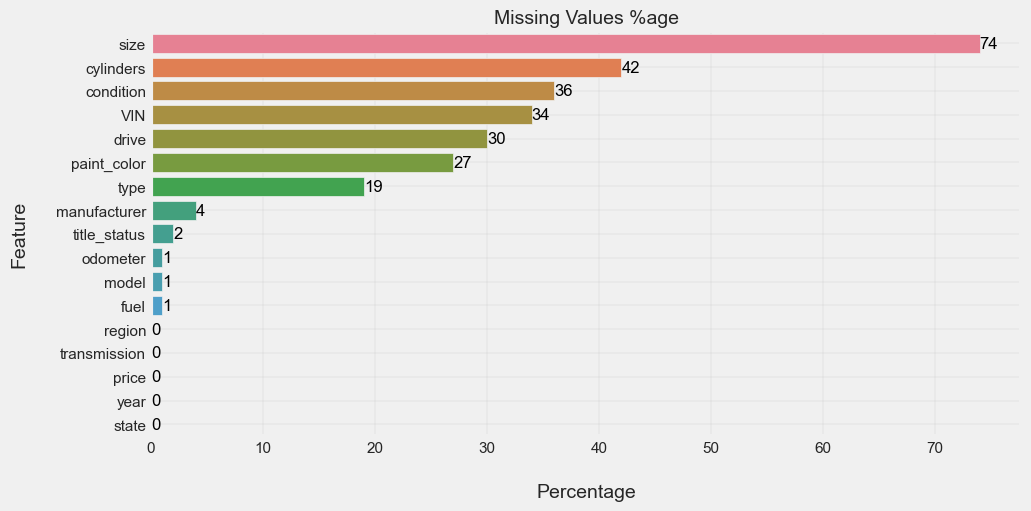

In [77]:
plt.figure(figsize=(10,5),    )

ax = sns.barplot(data=dfmv, x='perc', y='feature', hue='feature')
ax.set_title("Missing Values %age",fontsize=14)
ax.set_xlabel("Percentage", fontsize=14, labelpad=20)
ax.set_ylabel("Feature", fontsize=14, labelpad=20)
ax.grid(True, which='both', linestyle='-', linewidth=0.25)
ax.legend

# Display the values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=12 ,fontweight='normal', color='black', label_type='edge')


plt.savefig('images/01_missingvalues.png', bbox_inches='tight', dpi=200)
plt.show()


## Inference
The plot above shows the percentage of **Missing data** across various features. Some of the key features that can have impact in correct predictions are 
1. Condition of the Vehicle
2. Drive,  ex. 4WD, 2WD 
3. Type, ex. Sedan, SUV, Truck etc.
4. Size of the Vehicle
5. Number of Cylinders
6. VIN (for identifying unique vehicles)

Few features with missing values can have lesser impact on the prediction. Some of the features with less missing values can be imputed using various techniques.


In [78]:
# Check for Missing values
pd.DataFrame(dfVehicles.isna().sum()).T

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,0,0,0,10284,2965,103469,120275,1824,1500,4597,1376,97976,85392,212318,55334,76748,0


### Data Cleaning - Outlier Removal in Price by Inter-quartile range filtering

In [79]:
# Use inter quartile range to filter the outliers in price column
iqr = dfVehicles['price'].quantile(.75) - dfVehicles['price'].quantile(.25)

lower_bound = dfVehicles['price'].quantile(.25) - 1.5 * iqr
upper_bound = dfVehicles['price'].quantile(.75) + 1.5 * iqr
print(iqr, lower_bound, upper_bound)

19092.0 -17738.0 58630.0


In [80]:
# Peform IQR calcs
df_iqr = dfVehicles[(dfVehicles['price'] > lower_bound) & (dfVehicles['price'] < upper_bound)].copy()

iqr_data_lost = 1-(df_iqr.shape[0]/dfVehicles.shape[0])
print("We lost {:.2%} of the data by the IQR method".format(iqr_data_lost))

We lost 2.28% of the data by the IQR method


In [81]:
p = [0.05, .85,.95, .99]
df_iqr['price'].describe(p)

count   281935.00
mean     20937.59
std      11938.60
min       5015.00
5%        6000.00
50%      18500.00
85%      34990.00
95%      42990.00
99%      52995.00
max      58600.00
Name: price, dtype: float64

In [82]:
# Now copy the data to main table dfVechiles after IQL outlier filtering
dfVehicles = df_iqr.copy()

### Outliers Visualization
Boxplot below shows the spread of vehicles in various conditions.  Here all the records with **price upto USD 300,000** were considered.  After running the above Inter Quartile Range exclusion, the max price dropped to around **USD60,000**.
Need to evaluate the accuracy of the prediction with the modified data.

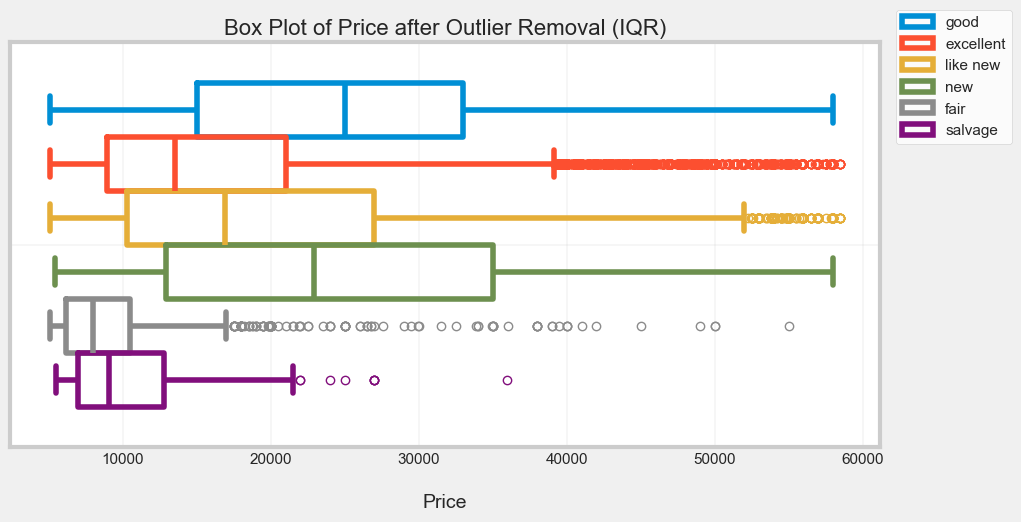

In [83]:
plt.figure(figsize=(10,5),)
sns.set_style('whitegrid')
ax = sns.boxplot(data=dfVehicles, x='price', vert=False,  hue='condition', fill=False)
ax.set_title("Box Plot of Price after Outlier Removal (IQR)",fontsize=16)
ax.set_xlabel("Price", fontsize=14, labelpad=20)
# ax.set_ylabel("Price", fontsize=16, labelpad=20)
ax.grid(True, which='both', linestyle='-', linewidth=0.25)
ax.legend(loc='best',  bbox_to_anchor=(1.01,1.1))

plt.savefig('images/02_price_outliers.png', bbox_inches='tight', dpi=200)
plt.show()


### Inference:  
Outliers are excluded in general, however they exist in individual condition bucket. Need to evaluate the impact of this filtering activity.

### Missing Manufacturer, Model, Fuel, Title Status, Transmission and Odometer

In [84]:
# Set Manufacturer and model to 'Uknown', where not present
dfVehicles['manufacturer'] = dfVehicles['manufacturer'].fillna('Unknown')
dfVehicles['model'] = dfVehicles['model'].fillna('Unknown')

# fill the missing value in 'fuel' with 'most frequently used-gas' as the numbers are small at 0.6%, 1867 records
dfVehicles['fuel'].fillna('gas', inplace=True)

# fill the missing value in 'title_status' with 'most frequently used-clean' as the numbers are small at 1.8%, 5889 records
dfVehicles['title_status'].fillna('clean', inplace=True)

dfVehicles['transmission'].fillna('automatic', inplace=True)

## Fill the missing 'odomoter' column with median of existing data. as the percentage of missing values is low 
dfVehicles['odometer'] = dfVehicles['odometer'].fillna(dfVehicles['odometer'].median())
dfVehicles['odometer'] = dfVehicles['odometer'].astype(int)

print('Done. Fixed missing values in manufacturer, model, fuel, title_status, transmission and odometer columns')

Done. Fixed missing values in manufacturer, model, fuel, title_status, transmission and odometer columns


In [85]:

# dfVehicles[['price']].describe(p)

### Data Preprocessing - Fill Missing Condition and Cylinders 
The strategy is to update the missing 'condition' column based on same proportion as existing values. i.e. If 'new' conditions make up 30% of existing values, then 30% of missing values is updated to 'new' and same for other conditions

Same apprroach for updating missing values in 'cylinders' column


In [86]:
# Update a specified number of random missing values in a DataFrame column with a given value.

# Args:
# - dfup: pandas DataFrame
# - column_name: str, name of the column to update
# - no_of_recs: int, number of rows to update
# - value_to_use: value to fill in the missing entries
# Returns:
# - Updated DataFrame

def update_missing_values_proportionally(dfup, column_name, no_of_recs, value_to_use):
    # Get indices of rows with missing values in the specified column
    missing_indices = dfup[dfup[column_name].isna()].index
    
    # Check if the number of rows to update is less than or equal to the number of missing values
    if no_of_recs > len(missing_indices):
        no_of_recs = len(missing_indices)

    # Randomly select indices to update
    indices_to_update = np.random.choice(missing_indices, size=no_of_recs, replace=False)
    
    # Update the selected rows with the specified value
    dfup.loc[indices_to_update, column_name] = value_to_use
    

In [87]:
# update the missing 'condition' column based on same proportion as existing values
# i.e. apportion and update 118544 missing values with

c_ratio = dfVehicles['condition'].isna().sum() / dfVehicles['condition'].count()

dfc = dfVehicles['condition'].value_counts()
dfc = dfc.reset_index()
dfc['proportion'] = np.int64(np.round(dfc['count'] * c_ratio))
# Using apply() to call the custom function with column values
dfc.apply(lambda row: update_missing_values_proportionally(dfVehicles, 
                                                           'condition', row['proportion'],row['condition']), axis=1)

print('Done. Fixed missing values condition column')

Done. Fixed missing values condition column


In [88]:
#update the missing 'cylinders' column based on same proportion as existing values
cy_ratio = dfVehicles['cylinders'].isna().sum() / dfVehicles['cylinders'].count()

dfcy = dfVehicles['cylinders'].value_counts()
dfcy = dfcy.reset_index()
dfcy['proportion'] = np.int64(np.round(dfcy['count'] * cy_ratio))

# Using apply() to call the custom function with column values
dfcy.apply(lambda row: update_missing_values_proportionally(dfVehicles, 
                                                            'cylinders', row['proportion'],row['cylinders']), axis=1)

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
dtype: object

In [89]:
# convert 'cylinders' column to int by removing the text 'cyclinders' and replacing 'other' with 4, the most frequent
dfcy = dfVehicles[['cylinders']]
dfcy['cylinders'].mask(dfcy['cylinders'] == 'other', '4', inplace=True)
dfcy['cylinders'] = dfcy['cylinders'].str.split(' ', expand=True)[0]
dfcy['cylinders'] = dfcy['cylinders'].astype(int)
# dfcy['cylinders'].value_counts()
dfVehicles['cylinders'] = dfcy['cylinders']
print('Done. Fixed missing values cylinders column and converted to numerical column')

Done. Fixed missing values cylinders column and converted to numerical column


### Consolidated Data Analysis after Quality Checks and Data updates

In [90]:
#copy 'price', 'year', 'manufacturer', 'condition','cylinders', 'fuel', 'odometer', 'transmission'
# columns to new table for further processing and modeling activities.

dfProcessed = dfVehicles[['price', 'year', 'manufacturer', 'condition','cylinders', 'fuel', 'odometer', 'transmission']]

In [91]:
# insert a new colum with log of price
dfProcessed.insert(loc=1, column='price_log',value=np.log(dfProcessed['price']))

In [92]:
pd.DataFrame(dfProcessed.isna().sum()).T

,price,price_log,year,manufacturer,condition,cylinders,fuel,odometer,transmission
0,0,0,0,0,0,0,0,0,0


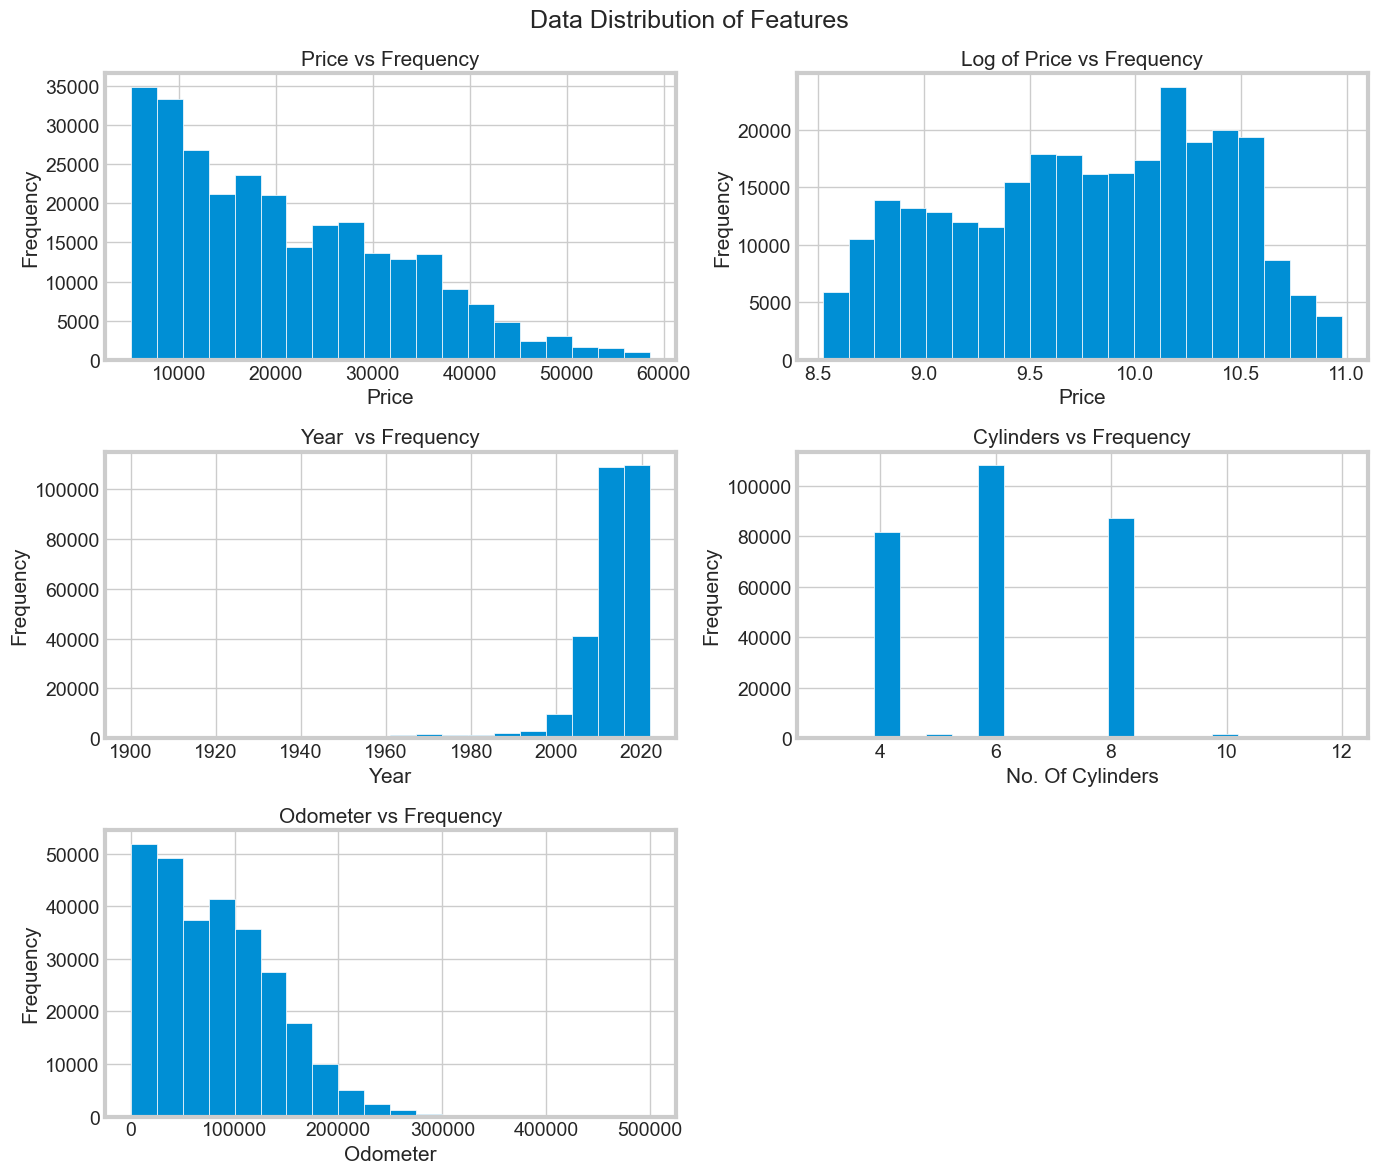

In [93]:
# Histogram/Barplots for numerical variables

df_numeric = dfProcessed.select_dtypes(include=['float64', 'int64', 'int'])
df_numeric.drop(df_numeric[df_numeric.odometer > 500000].index, inplace=True)
ax = df_numeric.hist(bins=20, figsize=(14, 12), xlabelsize=(14), ylabelsize=(14))
plt.suptitle('Data Distribution of Features', fontsize=18)
ax[0,0].set_title('Price vs Frequency', fontsize=15)
ax[0,0].set_xlabel('Price', fontsize=15)
ax[0,0].set_ylabel('Frequency', fontsize=15)

ax[0,1].set_title('Log of Price vs Frequency', fontsize=15)
ax[0,1].set_xlabel('Price', fontsize=15)
ax[0,1].set_ylabel('Frequency', fontsize=15)

ax[1,0].set_title('Year  vs Frequency', fontsize=15)
ax[1,0].set_xlabel('Year', fontsize=15)
ax[1,0].set_ylabel('Frequency', fontsize=15)

ax[1,1].set_title('Cylinders vs Frequency', fontsize=15)
ax[1,1].set_xlabel('No. Of Cylinders', fontsize=15)
ax[1,1].set_ylabel('Frequency', fontsize=15)

ax[2,0].set_title('Odometer vs Frequency', fontsize=15)
ax[2,0].set_xlabel('Odometer', fontsize=15)
ax[2,0].set_ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.savefig('images/03_data_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

### Distribution of Price across various vechile conditions (new, good, etc.)

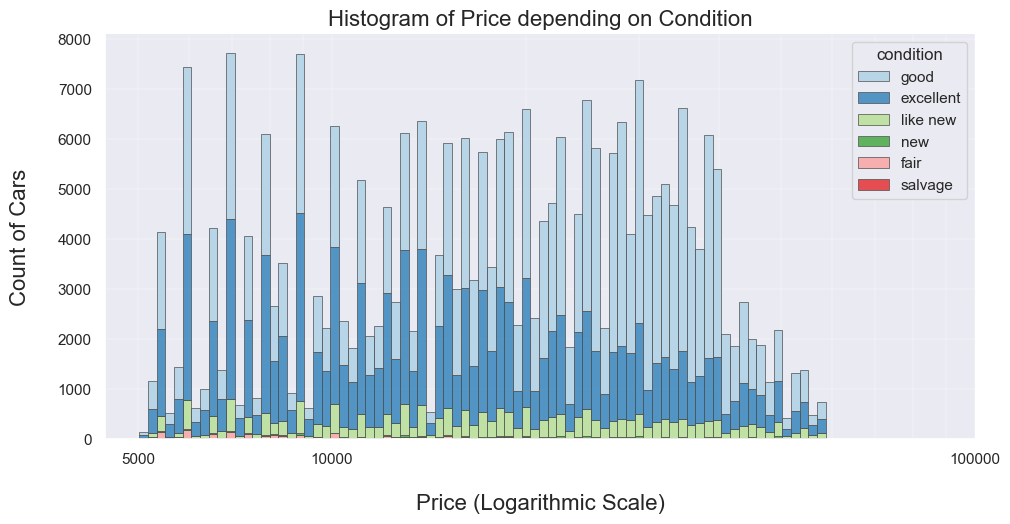

In [94]:
# Plot a bar chart to show the price across vehicle conditions.
sns.set_theme(style="darkgrid", palette='tab10')

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot( dfProcessed,x="price", hue="condition", multiple="stack",
    palette="Paired", edgecolor=".3", linewidth=.5, log_scale=True,)

ax.set_title("Histogram of Price depending on Condition",fontsize=16)
ax.set_xlabel("Price (Logarithmic Scale)", fontsize=16, labelpad=20)
ax.set_ylabel("Count of Cars", fontsize=16, labelpad=20)
ax.grid(True, which='both', linestyle='-', linewidth=0.25)
# ax.legend(loc='best',  bbox_to_anchor=(1.01,1.1))

ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xticks([5000, 10000, 100000])
plt.savefig('images/04_price_distribution.png', bbox_inches='tight', dpi=200)
plt.show()


### Inference :
The above plot shows mainly vehicle in 'good' and 'excellent' condition occupying all price points.  There are less number of vehicles in 'new or 'like_new' condition underscoring that this is used car market is thriving.

## Bivariate Analysis

In [95]:
dfbv = dfProcessed[['price', 'year', 'cylinders', 'odometer']]
corr = dfbv.corr(numeric_only = True)

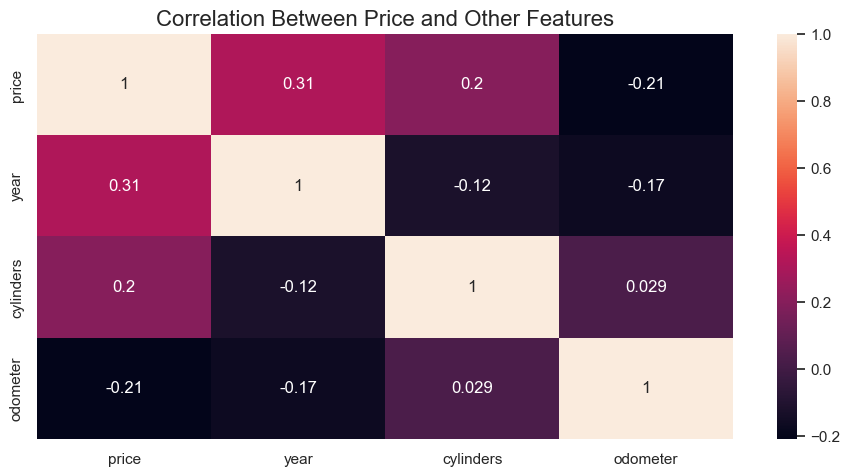

In [96]:
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot = True);
plt.title('Correlation Between Price and Other Features', fontsize=16)
plt.savefig('images/05_corr01.png', bbox_inches='tight', dpi=150)

### Inference:
There is no **strong** correlation between any of the features, although it appears that there a **negative** correlation between "price" and "odometer" which is to be expected. 

In [97]:
mask = np.triu(np.ones_like(dfbv.corr(numeric_only = True).round(2)))

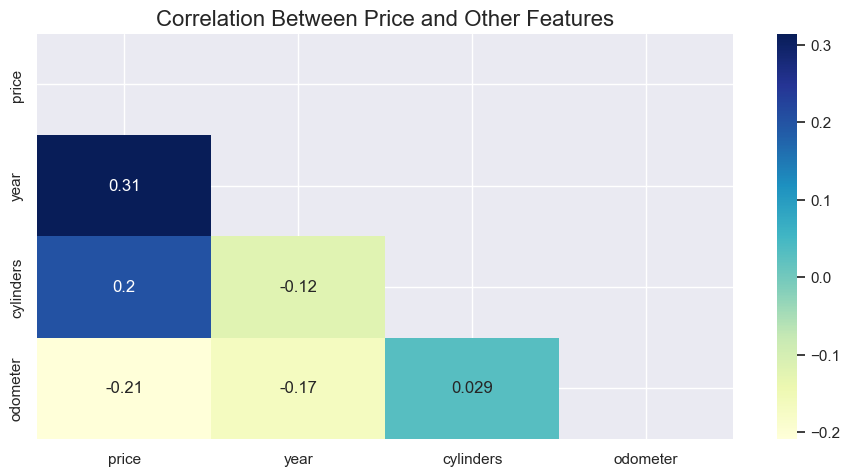

In [98]:
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu");
plt.title('Correlation Between Price and Other Features', fontsize=16)
plt.savefig('images/06_corr02.png', bbox_inches='tight', dpi=200)

### Categorical Values Analysis

### Manufacturer

In [99]:
# top_10 = dfProcessed.groupby('manufacturer')['price'].agg(['count','max']).sort_values(by='count', ascending=False).head(10)

# Your existing groupby and aggregation
agg_df = dfProcessed.groupby('manufacturer')['price'].agg(['count', 'max'])

# Sort and get the top 10 manufacturers
top_10 = agg_df.sort_values(by='count', ascending=False).head(10)

# Identify all manufacturers not in the top 10
remaining = agg_df.loc[~agg_df.index.isin(top_10.index)]
total_count = pd.DataFrame({'count': [remaining['count'].sum()],'max':[remaining['max'].max()],'manufacturer':'All Others'}).set_index('manufacturer')
top_10 = pd.concat([top_10, total_count], ignore_index=False)
top_10 = top_10.reset_index()
top_10


# Create the pie chart
fig = px.pie(top_10, values='count', names='manufacturer', hole=0.5, )
fig.update_traces(textinfo='percent + value', textfont_size=15)
fig.update_layout(title_text= 'Used Cars by Manufacturer', title_x=0.5, title_font=dict(size=24),font=dict(size=16),)

fig.write_image('images/07_usedcars-mfg.png', width=1000, height=800)
# Show the chart
fig.show()

### Plot the chart with vehicles grouped by Manufactuer

### Inference:
The data shows the Top 10 car makers with their market share. Other car makers are grouped under 'All Others' and 'Unknown' 

### Number of Cylinders

In [100]:
#Plot the number of vehicles by cylinders

top = dfProcessed.groupby('cylinders')['price'].agg(['count','max']).reset_index()

# Create the pie chart

fig = px.pie(top, values='count', names='cylinders', hole=0.5)
fig.update_traces(textinfo='percent + value', textfont_size=15)
fig.update_layout(title_text= 'Used Cars by Number of Cylinders', title_x=0.5, title_font=dict(size=24),font=dict(size=14))

fig.write_image('images/08_usedcars-cyl.png', width=1200, height=1000, )
# Show the chart
fig.show()


### Inference
4, 6 and 8 cylinders are the most popular choice when considering the car indicating that vehicles with higher number of cylinders are not very widely used and is a niche market. Predictions of price for outliersare likely to be erroneous.

### Transmission and Price of vehicles.


In [101]:
auto = dfProcessed.query("transmission == 'automatic'")['transmission'].value_counts()[0]
manual = dfProcessed.query("transmission == 'manual'")['transmission'].value_counts()[0]
other = dfProcessed.query("transmission == 'other'")['transmission'].value_counts()[0]
auto

207670

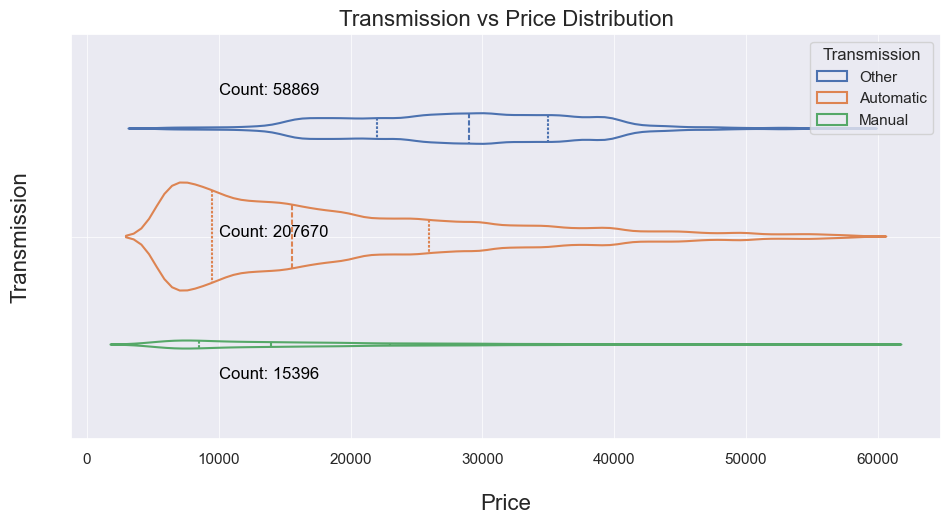

In [102]:
plt.figure(figsize=(10,5))
sns.set(style = 'darkgrid') 

ax = sns.violinplot(x='price', data=dfProcessed, hue='transmission', 
               fill=False, split=False, scale_hue=True, inner='quart', density_norm='count')

ax.set_title("Transmission vs Price Distribution",fontsize=16)
ax.set_xlabel("Price", fontsize=16, labelpad=20)
ax.set_ylabel("Transmission", fontsize=16, labelpad=20)
ax.grid(True, which='both', linestyle='-', linewidth=0.5)
# ax.legend()
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Other', 'Automatic','Manual'], title='Transmission')

# Add custom text
ax.text(10000, -0.35, f"Count: {other}",  size='medium', color='black')
ax.text(10000, 0.0, f"Count: {auto}",  size='medium', color='black')
ax.text(10000, 0.35, f"Count: {manual}",  size='medium', color='black')

plt.savefig('images/09_Trans_Price.png', bbox_inches='tight', dpi=200)

### Inference:
We can see that majority of both Automatic & Manual Transmission vehicles similarly priced than other transmission types

### Data Preparation for Modeling

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [103]:
## Save the processed file so far to new csv file.
# dfProcessed.to_csv('data/preprocessed.csv', sep=',', header=True)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [104]:
# Define a function for logging error metrics from various models
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

# Array for model metrics 
model_evaluation = []

In [105]:
# read the preprocessed data
dfmodel = pd.read_csv('data/preprocessed.csv',index_col=0)

In [106]:
# numeric_cols = df.select_dtypes(['int','float']).drop(columns={'price'}).columns.tolist()
numeric_cols = dfmodel.select_dtypes(['int','float']).columns.tolist()
df_numeric = dfmodel[numeric_cols].copy()
df_numeric.head()

,price,price_log,year,cylinders,odometer
27,33590,10.42,2014,8,57923
28,22590,10.03,2010,8,71229
29,39590,10.59,2020,8,19160
30,30990,10.34,2017,8,41124
31,15000,9.62,2013,6,128000


### Baseline Prediction
Create a baseline prediction model

In [107]:
# numerical cols
X = df_numeric.drop(columns = ['price','price_log'])

# target column Price
y = df_numeric['price']

# split the data into Training and Test data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

print("=" * 50)

print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Training Features Shape: (225548, 3)
Testing Features Shape: (56387, 3)
Training Labels Shape: (225548,)
Testing Labels Shape: (56387,)


In [108]:
# create a dummy regressor before scaling the numerical values
dummy = DummyRegressor()
# fit the model
dummy.fit(X_train, y_train)

y_train_pred = dummy.predict(X_train)
y_test_pred = dummy.predict(X_test)

# get error metrics
error_dummy = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_dummy['Model Name']='Dummy Regression-Before Std. Scaler'

# add the entry to model_evaluation comparison table
model_evaluation = (pd.DataFrame([error_dummy]))
model_evaluation


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler


In [109]:
# Create a dummy regressor AFTER scaling the numerical values
dummy = DummyRegressor()

#run StandardScaler before fitting the model
scale = StandardScaler()

X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)

# fit the model
dummy.fit(X_train_sc, y_train)

y_train_pred = dummy.predict(X_train_sc)
y_test_pred = dummy.predict(X_test_sc)

# get error metrics
error_dummy_sc = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_dummy_sc['Model Name']='Dummy Regression-After Std. Scaler'

# add the entry to model_evaluation comparison table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_dummy_sc]))], ignore_index=True)
model_evaluation


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler


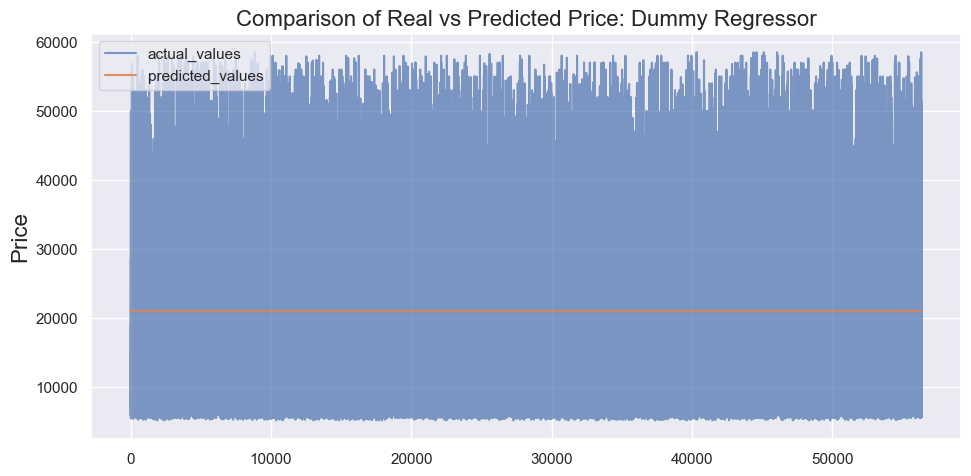

In [110]:
# Plot a line graph to visualize
plt.figure(figsize=(10,5))
x = list(range(0, len(y_test)))
sns.lineplot(x = x, y = y_test, label = 'actual_values', alpha = 0.7)
sns.lineplot(x = x, y = y_test_pred, label = 'predicted_values', alpha=0.9)
plt.title("Comparison of Real vs Predicted Price: Dummy Regressor", fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.savefig('images/11_dummy_real-vs-prediction.png', bbox_inches='tight', dpi=150)
plt.show()


### Linear Regression
Now we can try building a linear regression model and see if the prediction can be improved

In [111]:
lr = LinearRegression()

#run StandardScaler before fitting the model
scale = StandardScaler()

X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)

# fit the model with scaled X_train
lr.fit(X_train_sc, y_train)

#predict the values on training & test data
y_train_lr_pred = lr.predict(X_train_sc)
y_test_lr_pred = lr.predict(X_test_sc)

# get error metrics
error_lr_sc = error_metrics(y_train, y_train_lr_pred, y_test, y_test_lr_pred)
error_lr_sc['Model Name']='Linear Regression-After Std. Scaler'
# print(error_lr_sc)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_lr_sc]))], ignore_index=True)
model_evaluation


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler


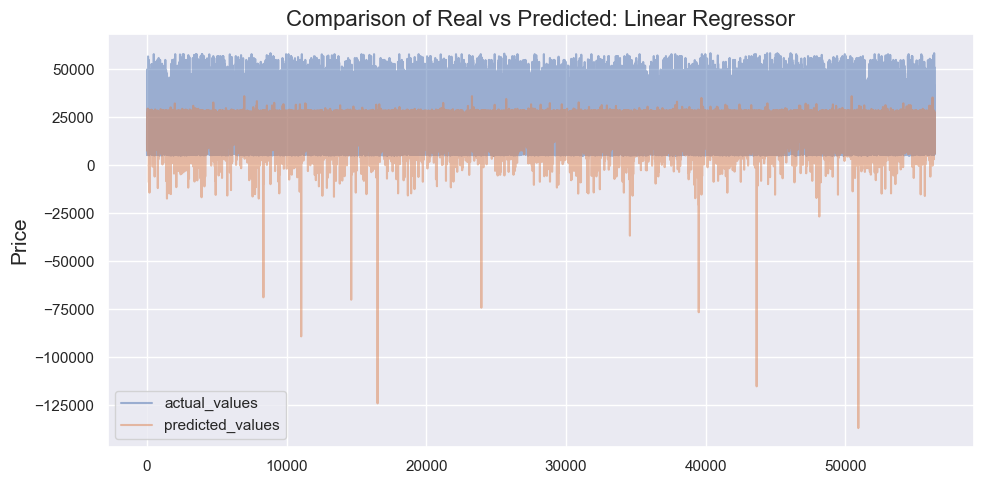

In [112]:
# Let us visualize and see how the linear regression model performs
plt.figure(figsize=(10,5))
sns.lineplot(x = x, y = y_test, label = "actual_values", alpha = 0.5);
sns.lineplot(x = x, y = y_test_lr_pred, label = "predicted_values", alpha = 0.5);
plt.title("Comparison of Real vs Predicted: Linear Regressor", fontsize=16)
plt.ylabel("Price",fontsize=15);
plt.savefig('images/12_Linear Regression real-vs-prediction.png', bbox_inches='tight', dpi=150)
plt.tight_layout()
plt.show()

### Pipelines
We will create a pipeline for using categorical values and run other regression models like Lasso and Ridge

In [113]:
# split the data into Training and Test data sets and target 
# both numerical and categorical cols into X data set
X = dfmodel.drop(columns = ['price','price_log','manufacturer'])

# target column Price
y = df_numeric['price']

# split the data into Training and Test data sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

print("=" * 50)

print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")


Training Features Shape: (225548, 6)
Testing Features Shape: (56387, 6)
Training Labels Shape: (225548,)
Testing Labels Shape: (56387,)


In [114]:
# Select the categorical features that will be used in building the model
# Now 'Condition', 'Fuel', and 'Transmission' will be included for building the model
# create a OneHotEncoder for the categorical values
# Create a transformer, use pass through as the training and test data has been scaled in the earlier step

categories = ['condition','fuel','transmission']
ohe = OneHotEncoder(sparse_output=False, drop='first')
transformer = make_column_transformer((ohe, categories), remainder = StandardScaler())

### Lasso Regressor
Now we will train the model with the Lasso Regressor with Cross Validation = 5

In [115]:
# Create a pipeline for training the model. 
# Use transformer for data encoding & scaling
pipe = Pipeline([
    ('encoder',transformer),
    ('poly', PolynomialFeatures()),
    ('model', Lasso())
])

# set up the param_grid for GridSearch cross validation
param_grid = {
    'model__alpha': [0.1,1,10],
    'poly__degree': [1, 2,]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise',verbose=0)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

error_pipe = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_pipe['Model Name']='Grid Search With Lasso'
# print(error_pipe)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_pipe]))], ignore_index=True)
model_evaluation


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['condition', 'fuel',
                                                   'transmission'])])),
                ('poly', PolynomialFeatures()), ('model', Lasso(alpha=1))])


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler
3,6410.75,72160601.10,8494.74,0.49,6409.32,74105045.60,8608.43,0.48,Grid Search With Lasso


### Ridge Regressor
Now we will train the model with the Ridge Regressor with Cross Validation = 5

In [116]:
# Create a pipeline for training the model. 
# Use transformer for data encoding & scaling
pipe = Pipeline([
    ('encoder',transformer),
    ('poly', PolynomialFeatures()),
    ('model', Ridge())
])

# set up the param_grid for GridSearch cross validation
param_grid = {
    'model__alpha': [0.1,1,10],
    'poly__degree': [1, 2,]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise',verbose=0)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

error_pipe = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_pipe['Model Name']='Grid Search With Ridge'
# print(error_pipe)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_pipe]))], ignore_index=True)
model_evaluation


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['condition', 'fuel',
                                                   'transmission'])])),
                ('poly', PolynomialFeatures()), ('model', Ridge(alpha=10))])


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler
3,6410.75,72160601.10,8494.74,0.49,6409.32,74105045.60,8608.43,0.48,Grid Search With Lasso
4,6406.10,72109815.32,8491.75,0.49,6404.99,74168484.29,8612.11,0.48,Grid Search With Ridge


###  Ridge Regressor and additional 'Manufacturer' column and Dummy Variable instead of OneHotEncoding

This model uses Lasso Regressor with Manufacturer column included as a categorical feature and boxcox transformer for 'odometer'


In [117]:
# Categories
categories = ['manufacturer','condition','fuel','transmission']
df_dummies = pd.get_dummies(dfmodel.query('odometer < 10000000  and year >= 2000'), columns=categories, drop_first=True)
df_dummies['odometer'], _ = boxcox(dfmodel.query('odometer < 10000000  and year >= 2000')['odometer'] + 1)  

X = df_dummies.drop(columns = ['price','price_log'])
y = df_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', Ridge())
])

# set up the param_grid for GridSearch cross validation
param_grid = {
    'model__alpha': [0.01, 0.1],
    'poly__degree': [1, 2]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise',verbose=0)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

error_pipe = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_pipe['Model Name']='Grid Search With Dummy, Mfg, Ridge'
# print(error_pipe)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_pipe]))], ignore_index=True)
model_evaluation


Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('model', Ridge(alpha=0.1))])


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler
3,6410.75,72160601.10,8494.74,0.49,6409.32,74105045.60,8608.43,0.48,Grid Search With Lasso
4,6406.10,72109815.32,8491.75,0.49,6404.99,74168484.29,8612.11,0.48,Grid Search With Ridge
5,4897.38,45101346.06,6715.75,0.68,4920.42,45870936.25,6772.81,0.68,"Grid Search With Dummy, Mfg, Ridge"


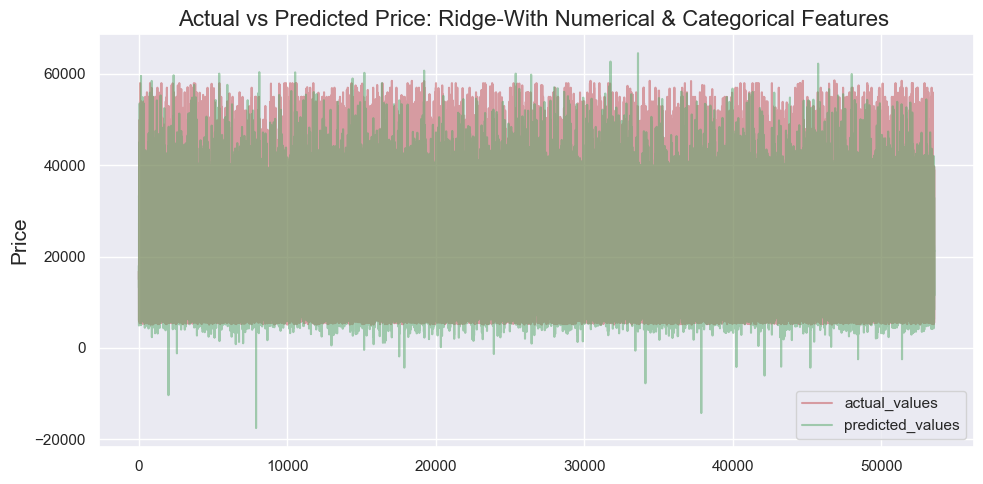

In [118]:
# Let us visualize and see how the linear regression model performs
x = list(range(0, len(y_test)))
plt.figure(figsize=(10,5))
sns.lineplot(x = x, y = y_test, label = "actual_values", alpha = 0.5, c='r',  );
sns.lineplot(x = x, y = y_test_pred, label = "predicted_values", alpha = 0.5, c='g');
plt.title("Actual vs Predicted Price: Ridge-With Numerical & Categorical Features ", fontsize=16);
plt.ylabel("Price",fontsize=15);
plt.savefig('images/13_Ridge Regression real-vs-prediction.png', bbox_inches='tight', dpi=150)
plt.tight_layout()
plt.show()

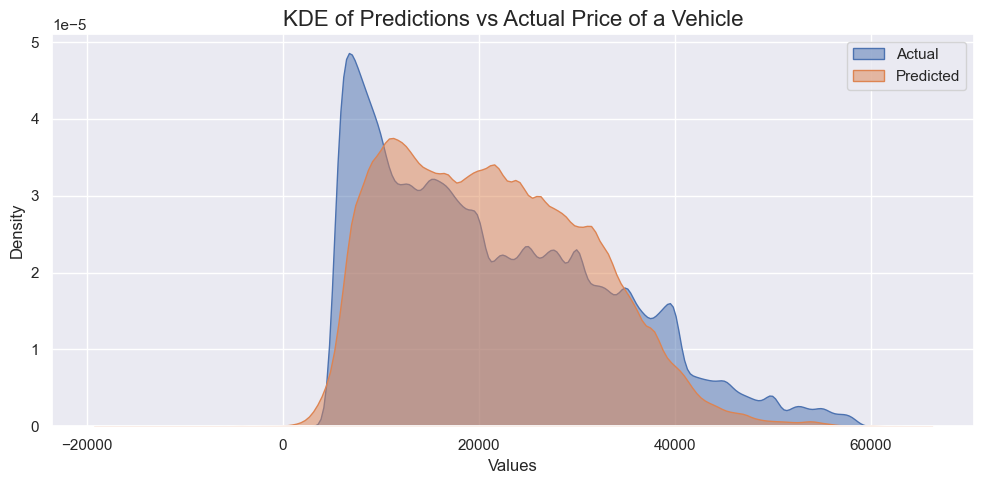

In [119]:
# KDE of Predictions vs Actual Price of a Vehicle

plt.figure(figsize=(10,5))
sns.kdeplot(y_test, label='Actual', fill=True, alpha=0.5, bw_adjust=0.5);
sns.kdeplot(y_test_pred, label='Predicted', fill=True, alpha=0.5, bw_adjust=0.5);

plt.title("KDE of Predictions vs Actual Price of a Vehicle", fontsize=16);
plt.xlabel("Values");
plt.ylabel("Density");
plt.legend();
plt.savefig('images/14_KDE real-vs-prediction.png', bbox_inches='tight', dpi=150)
plt.tight_layout()
plt.show()


### Inference
**The predictions by various models and their hyperparameters is not very accurate.  The best performance was by Ridge Regressor of degree 2 polynomial features with an alpha = 0.1 and an R2 score of 0.68. This means that predictions are only 68% accurate.**

In [120]:
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Example values
# r2 = 0.8  # R-squared value
# n = 100   # Number of observations
# k = 6     # Number of predictors

# 0.5971352913316251
r2 = 0.68  # R-squared value
n = 260000   # Number of observations
k = 7     # Number of predictors

adj_r2 = adjusted_r2(r2, n, k)
print(f"Adjusted R²: {adj_r2}")

Adjusted R²: 0.6799913843502877


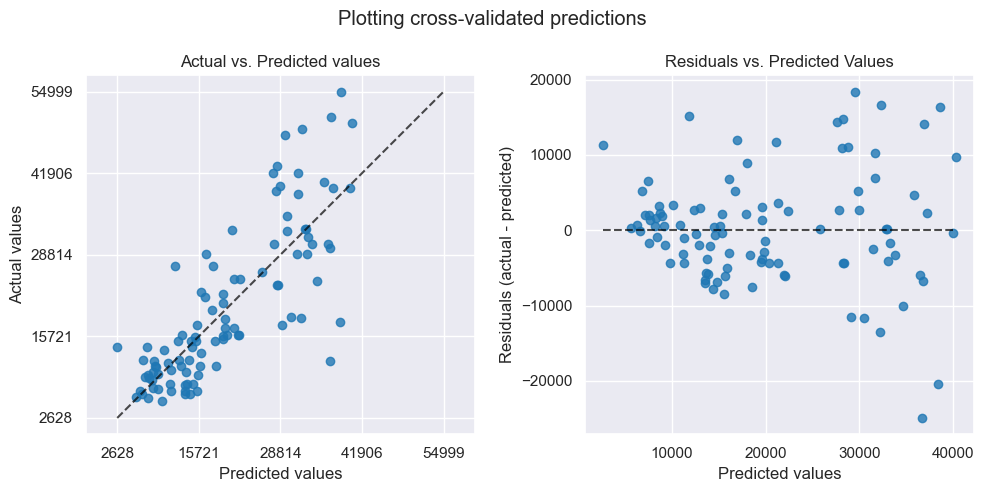

In [121]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")

plt.tight_layout()
plt.savefig('images/15_real-vs-prediction.png', bbox_inches='tight', dpi=150)
plt.show()

## Inference
The model is not very accurate as shown in the scatter plots above.  The accuracy is about 68%

## Split the data in TRAIN, VALIDATION AND TEST datasets and run the model to predict accuracy. - with PolynominalFeatures Degree = 1


In [122]:
# Categories
categories = ['manufacturer','condition','fuel','transmission']
df_dummies = pd.get_dummies(dfmodel.query('odometer < 10000000  and year >= 2000'), columns=categories, drop_first=True)
df_dummies['odometer'], _ = boxcox(dfmodel.query('odometer < 10000000  and year >= 2000')['odometer'] + 1)  

X = df_dummies.drop(columns = ['price','price_log'])
y = df_dummies['price']

# First split: separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', Ridge())
])

# set up the param_grid for GridSearch cross validation
param_grid = {
    'model__alpha': [0.1,],
    'poly__degree': [1]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise',verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

# Validate the model
val_score = best_model.score(X_val, y_val)
print(f"Validation score: {val_score}")

# Predict on test set
# y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

error_poly = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_poly['Model Name']='Grid Search With Degree-2 Polynomials'
# print(error_pipe)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_poly]))], ignore_index=True)
model_evaluation


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__alpha=0.1, poly__degree=1;, score=-55211849.502 total time=   0.1s
[CV 2/5] END model__alpha=0.1, poly__degree=1;, score=-55223446.952 total time=   0.1s
[CV 3/5] END model__alpha=0.1, poly__degree=1;, score=-55205642.528 total time=   0.1s
[CV 4/5] END model__alpha=0.1, poly__degree=1;, score=-55341099.594 total time=   0.1s
[CV 5/5] END model__alpha=0.1, poly__degree=1;, score=-54299265.475 total time=   0.1s
Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('model', Ridge(alpha=0.1))])
Validation score: 0.6111151075493867


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler
3,6410.75,72160601.10,8494.74,0.49,6409.32,74105045.60,8608.43,0.48,Grid Search With Lasso
4,6406.10,72109815.32,8491.75,0.49,6404.99,74168484.29,8612.11,0.48,Grid Search With Ridge
5,4897.38,45101346.06,6715.75,0.68,4920.42,45870936.25,6772.81,0.68,"Grid Search With Dummy, Mfg, Ridge"
6,5631.76,55021233.01,7417.63,0.61,5660.18,55842392.21,7472.78,0.61,Grid Search With Degree-2 Polynomials


Number of coefficients: 53


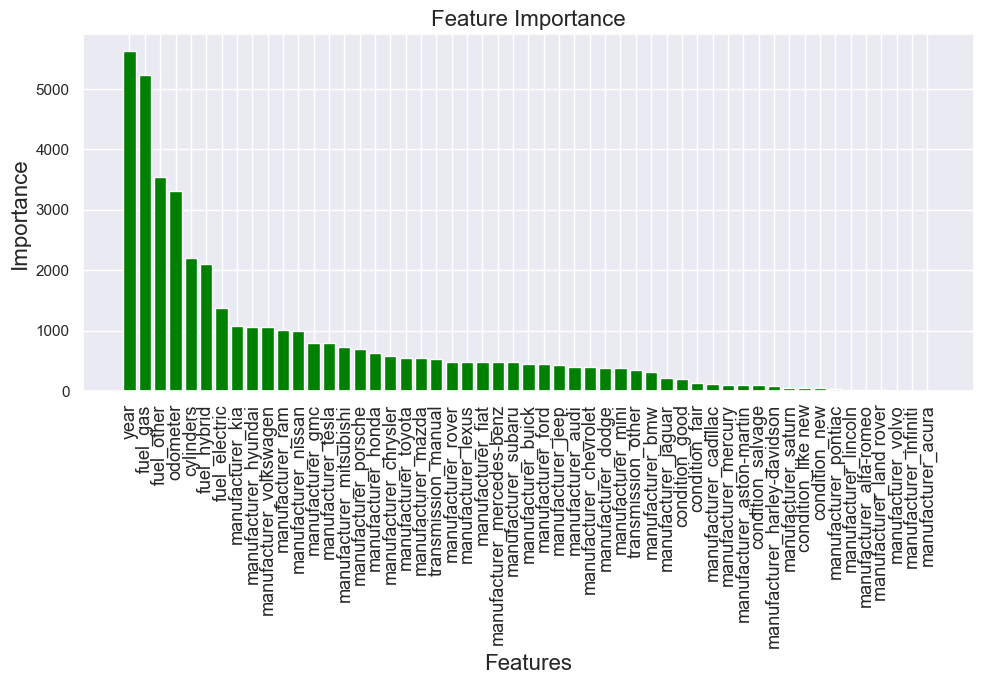

In [123]:
## Get importance values for features at degree 1
## evaluate their rankings and contribution to prediction
coefficients = grid_search.best_estimator_.named_steps['model'].coef_
print("Number of coefficients:", len(coefficients))


importance = np.abs(coefficients)
#create a data frame for features and importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

#Visualize the results
plt.figure(figsize=(10, 7))
plt.bar(feature_importance['feature'], feature_importance['importance'], color='green')
plt.xticks(rotation=90, fontsize=13)
plt.xlabel('Features', fontdict=dict(size=16))
plt.ylabel('Importance', fontdict=dict(size=16))
plt.title('Feature Importance', fontdict=dict(size=16))
plt.tight_layout()

plt.savefig('images/16_feature_importance-P1.png', bbox_inches='tight', dpi=150)
plt.show()

# Print the top 5 most important features
# print("Top 5 most important features:")
# print(feature_importance.head())


## Inference:
### Top 5 most important features:
|Feature Index|Feature|Importance|
|-------|----------|-------------|
|0|year|5623.74|
|48|fuel_gas|5228.65|
|50|fuel_other|3541.17|
|2|odometer|3314.55|
|1|cylinders|2200.70|

This model was built using polynomial features **degree = 2**. As seen in the chart, after initial 6, the feature importance start rapid drop

## Finally split the data in TRAIN, VALIDATION AND TEST datasets and run the model to predict accuracy. - with PolynominalFeatures Degree = 2


In [124]:
# Categories
categories = ['manufacturer','condition','fuel','transmission']
df_dummies = pd.get_dummies(dfmodel.query('odometer < 10000000  and year >= 2000'), columns=categories, drop_first=True)
df_dummies['odometer'], _ = boxcox(dfmodel.query('odometer < 10000000  and year >= 2000')['odometer'] + 1)  

X = df_dummies.drop(columns = ['price','price_log'])
y = df_dummies['price']

# First split: separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', Ridge())
])

# set up the param_grid for GridSearch cross validation
param_grid = {
    'model__alpha': [0.1,],
    'poly__degree': [2]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise',verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

# Validate the model
val_score = best_model.score(X_val, y_val)
print(f"Validation score: {val_score}")

# Predict on test set
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

error_poly = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_poly['Model Name']='Grid Search With Degree-1 Polynomials'
# print(error_pipe)

# add it to the model evaluation table
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_poly]))], ignore_index=True)
model_evaluation


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__alpha=0.1, poly__degree=2;, score=-45359879.904 total time=   2.9s
[CV 2/5] END model__alpha=0.1, poly__degree=2;, score=-45341135.912 total time=   2.8s
[CV 3/5] END model__alpha=0.1, poly__degree=2;, score=-45496450.185 total time=   2.8s
[CV 4/5] END model__alpha=0.1, poly__degree=2;, score=-45782346.519 total time=   3.1s
[CV 5/5] END model__alpha=0.1, poly__degree=2;, score=-44546569.169 total time=   3.0s
Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('model', Ridge(alpha=0.1))])
Validation score: 0.6791031275259756


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-Before Std. Scaler
1,9994.45,142491487.18,11936.98,0.00,10014.15,142682200.53,11944.97,-0.00,Dummy Regression-After Std. Scaler
2,8672.20,116819098.64,10808.29,0.18,8646.45,114960074.77,10721.94,0.19,Linear Regression-After Std. Scaler
3,6410.75,72160601.10,8494.74,0.49,6409.32,74105045.60,8608.43,0.48,Grid Search With Lasso
4,6406.10,72109815.32,8491.75,0.49,6404.99,74168484.29,8612.11,0.48,Grid Search With Ridge
5,4897.38,45101346.06,6715.75,0.68,4920.42,45870936.25,6772.81,0.68,"Grid Search With Dummy, Mfg, Ridge"
6,5631.76,55021233.01,7417.63,0.61,5660.18,55842392.21,7472.78,0.61,Grid Search With Degree-2 Polynomials
7,4887.79,44901018.60,6700.82,0.68,4921.49,45903836.62,6775.24,0.68,Grid Search With Degree-1 Polynomials


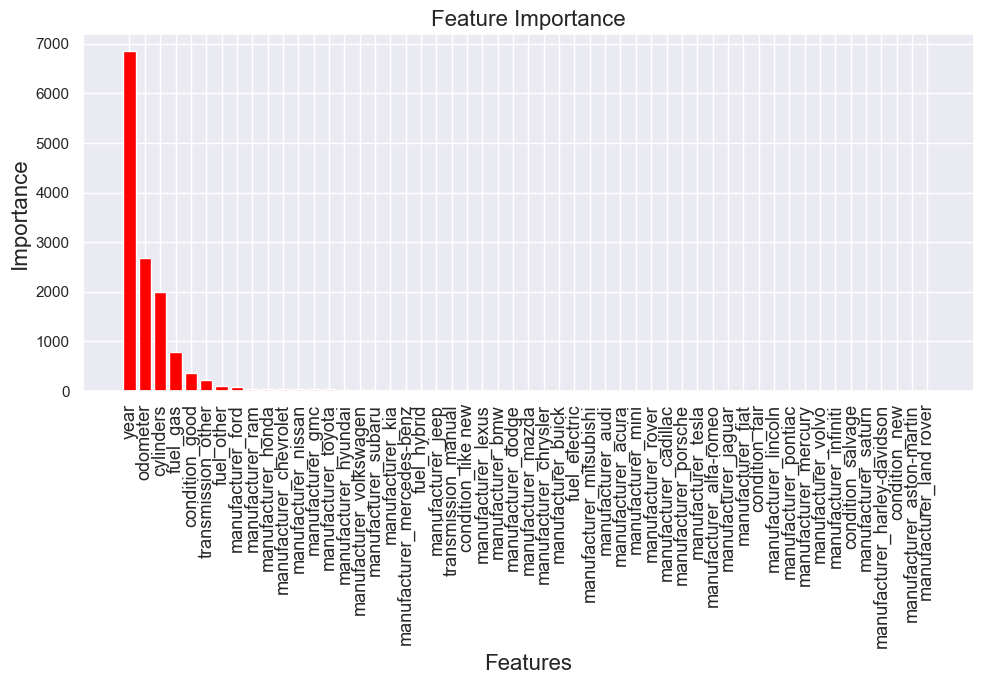

In [125]:
## Get importance values for features at degree 2
## evaluate their rankings and contribution to prediction
original_feature_names = X.columns.tolist()
poly_features = best_model.named_steps['poly'] # the polynomial feature names with degree 2

# get the coefficients of the original features from the big list of polynomial features.
# polynomila feature list is about 1484 items long

# I am interested in only the original features coefficients as the degree 2 did not improve from degree 1
original_feature_indices = [poly_features.get_feature_names_out().tolist().index(feat) for feat in original_feature_names]
original_coefficients = best_model.named_steps['model'].coef_[original_feature_indices]

# create a dataframe for these features
importance_df = pd.DataFrame({'Feature': original_feature_names, 'Coefficient': original_coefficients})
# only absolute values & sorted
importance_df['Importance'] = abs(importance_df['Coefficient'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
# feature_importance = feature_importance.sort_values('importance', ascending=False)
# Visualize the results
plt.figure(figsize=(10, 7))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='red' )
plt.xticks(rotation=90, fontsize=13)
plt.xlabel('Features',fontdict=dict(size=16))
plt.ylabel('Importance',fontdict=dict(size=16))
plt.title('Feature Importance',fontdict=dict(size=16))
plt.tight_layout()
plt.savefig('images/17_feature_importance_p2.png', bbox_inches='tight', dpi=150)
plt.show()


## Inference:
### Top 5 most important features:
|Feature Index|Feature|Importance|
|-------|----------|-------------|
|0|year|5623.74|
|48|fuel_gas|5228.65|
|50|fuel_other|3541.17|
|2|odometer|3314.55|
|1|cylinders|2200.70|

This model was built using polynomial features **degree = 1**. As seen in the chart, after initial 3, the feature importance start rapid drop

### Evaluation - Model Performance Analysis

The **Used Car Price** prediction model for sales data from the given data set is not a good model that can be used for predicting the price.
Primary reasons for poor performance are:
1. There are approximately 120,000 Vechicles with **SAME** VIN number, which are duplicated many times along with **Year** and **Price** with random data for other features.  
2. The **Model** of a vehicle, which is one of the key deciding factor is not an item with correct category making it unusable for building the model
3. Other key factors like **Condition, Size, Type, Drive**  are having missing values between **20% to 75%**
4. Sizeable portion **Odometer** readings appear to be random with readings like **100 million miles**
5. Correlation between features like **Price, Year, Condition, Type, Cylinders, Odometer** are all poor and low

### Recommedations & Deployment Decision

#### Based on the model prediction evaluations below are the recommendations.
1. Accuracy of Prediction is **68%**.  The performance is **NOT** reliable

2. More reliable data has to be sourced, so that key features are not missing important data. 

3. The current models are **NOT** suitable for predicting Price accurately and **should NOT be deployed**

